# Submission 1, ML Assignment 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read raw test data

In [2]:
amazon = pd.read_csv('/Users/andrewlevinson/programs/parsons/spring-2019/machine-learning-class/machine-learning/assignment-1/data/raw_data_test.csv')

print(amazon.shape)

(91000, 14)


In [3]:
print(amazon.head())
print(amazon['helpful'].mean())

   Unnamed: 0  Unnamed: 0.1      Id   ProductId          UserId  \
0      450430        317629  317630  B002BUD5TK   AZ4EUUJVC8358   
1      209527        289838  289839  B003LPOUZM  A1BEU8FCL6JI4T   
2      329547        479010  479011  B001E5E074  A1XL72EEATTQY4   
3       46044        256379  256380  B001EQ55R2  A38XAAS5U05GY8   
4      162804        355065  355066  B001EQ4OBA   A6S4BCIF87GQ7   

                     ProfileName  HelpfulnessNumerator  \
0                          Kasia                     1   
1                 Linda "ln5229"                     0   
2  Michael J. Pruett "M P buyer"                     2   
3                         Judith                     0   
4            Reason "books_easy"                     1   

   HelpfulnessDenominator  Score        Time  \
0                       1      1  1340755200   
1                       0      5  1298851200   
2                       2      3  1343692800   
3                       0      5  1320451200   
4       

### Feature extraction on natural language data

In [4]:
# # http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# from sklearn.feature_extraction.text import CountVectorizer
# vectorizer = CountVectorizer()
# corpus = amazon.Text.as_matrix()
# X_bag_of_words = vectorizer.fit_transform(corpus)
# print(X_bag_of_words.toarray())

In [5]:
# vectorize Bag of Words from review text; as sparse matrix
# from sklearn.feature_extraction.text import HashingVectorizer
# hv = HashingVectorizer(n_features=2 ** 17, non_negative=True)
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazon.Text)
print(X_hv.shape)

/Users/andrewlevinson/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning: the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.
  " in version 0.21.", DeprecationWarning)


(91000, 131072)


In [6]:
# http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
# from sklearn.feature_extraction.text import TfidfTransformer
# transformer = TfidfTransformer()
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [7]:
print(type(X_tfidf))

<class 'scipy.sparse.csr.csr_matrix'>


### Create additional quantitative features

In [8]:
# features from Amazon.csv to add to feature set
# review word length
amazon['reviewLen'] = amazon['Text'].apply(lambda x: len(str(x).split(" ")))

# summary word length
amazon['sumLen'] = amazon['Summary'].apply(lambda x: len(str(x).split(" ")))

# upper case words in Text review
amazon['upper'] = amazon['Text'].apply(lambda x: len([x for x in x.split() if x.isupper()]))


X_quant_features = amazon[["Score", "reviewLen", "Time", "sumLen", "upper"]]
print(X_quant_features.head(10))
# print(type(X_quant_features))

   Score  reviewLen        Time  sumLen  upper
0      1         59  1340755200       3      5
1      5         29  1298851200       3      0
2      3         23  1343692800       1      2
3      5         42  1320451200       4      1
4      3         48  1290384000       6      4
5      1        116  1251504000       3      5
6      4         18  1214092800       3      0
7      5         61  1347667200       5      7
8      5         92  1318118400       3      0
9      1         62  1340150400       4      5


### Combine all quantitative features into a single sparse matrix

In [9]:
from scipy.sparse import csr_matrix, hstack
X_quant_features_csr = csr_matrix(X_quant_features)
X_combined = hstack([X_tfidf, X_quant_features_csr])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 131077)


### Create `X`, scaled matrix of features

In [10]:
# feature scaling
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler(with_mean=False)
sc = joblib.load('sc.pkl')
X = sc.transform(X_matrix)
print(X.shape)

(91000, 131077)


### create `y`, vector of Labels

In [11]:
y = amazon['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### predict `y` with the fit on the training set

In [12]:
# MODEL: Decision Tree Classifier
# from sklearn import tree
# dtc = tree.DecisionTreeClassifier(max_depth=100)
# dtc.fit(X_matrix, y)
# joblib.dump(dtc, 'dtc.pkl') # pickle
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X_matrix), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6708, 'Neg': 84292, 'TP': 2350, 'TN': 82406, 'FP': 1886, 'FN': 4358, 'Accuracy': 0.9313846153846154, 'Precision': 0.5547686496694996, 'Recall': 0.35032796660703636, 'desc': 'dtc'}


### ROC plot to compare performance of various models and fits

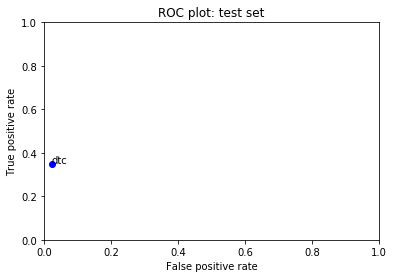

In [13]:
fits = [dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()